# Models with energy-dependent morphology in gammapy.

*Oleg Kalashev, EPFL*

source: https://gitlab.renkulab.io/oleg.kalashev/cta-gammapy.git

#### Motivation

Universe is not transparent for $\gamma$ rays with energy of TeV and above. 

Electron-photon cascades and secondary $\gamma$ rays:

Pair production: $$\gamma \gamma_b  ->  e^+ e^-$$

Inverse Compton scattering: $$$e \gamma_b  ->  e \gamma$$

Electrons are deflected by the intergalactic magnetic fields (IGMF) -> secondary $\gamma$ rays are also deflected.

Secondary $\gamma$ ray halo may appear arround distant sources. The source morphology depends on IGMF properties.


#### Setup

In [1]:
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import Models
from gammapy.data import DataStore
from gammapy.utils.regions import CircleSkyRegion
%matplotlib inline
import logging
from IPython.display import display
# from pathlib import Path
# from astropy.time import Time
# # Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from gammapy.data import DataStore
from pathlib import Path
from gammapy.datasets import (
    Datasets,
    MapDataset,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from gammapy.utils.regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import LightCurveEstimator
from gammapy.estimators.utils import resample_energy_edges, get_rebinned_axis
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    MapDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    TemplateSpatialModel,
    PointSpatialModel,
    ConstantSpectralModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.visualization import plot_spectrum_datasets_off_regions
log = logging.getLogger(__name__)
import os
from astropy.time import Time
GAMMAPY_DATA = os.path.join(os.getcwd(),'.') 
os.environ['GAMMAPY_DATA'] = GAMMAPY_DATA
CALDB = os.path.join(os.getcwd(),'IRFS') 
os.environ['CALDB'] = 'IRFS'

### Define region of interest and find observations

In [2]:
src_name='Mkn 501'
source = SkyCoord.from_name(src_name, frame='icrs', parse=False, cache=True)
print(source)

RA=source.ra
DEC=source.dec

data_store = DataStore.from_dir(".")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=RA,
    lat=DEC,
    radius="2 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

<SkyCoord (ICRS): (ra, dec) in deg
    (253.46756952, 39.76016913)>
Number of selected observations : 126


#### Analysis configuration

In [3]:
from gammapy.analysis import Analysis, AnalysisConfig

config = AnalysisConfig()

# Selecting the observations
max_observations = 10
config.observations.datastore = "$GAMMAPY_DATA"
config.observations.obs_ids = obs_ids[:max_observations]

# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": RA,
    "lat": DEC,
    "frame": 'icrs',
}

config.datasets.geom.wcs.width = {"width": "1 deg", "height": "1 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
config.datasets.geom.axes.energy_true.min = "0.5 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy_true.nbins = 20

config.datasets.background.method = "fov_background"

config.datasets.stack = True # first we will make stacked analysis

### Prepare stacked dataset

In [4]:
analysis_stacked = Analysis(config)
analysis_stacked.get_observations()
# run data reduction
analysis_stacked.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 10 out of 10.
Number of selected observations: 10
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 5000000439
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 5000000439
No default lower safe energy threshold defined for obs 5000000439
Running FoVBackgroundMaker
Computing dataset for observation 5000000440
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 5000000440
No default lower safe energy threshold defined for obs 5000000440
Running FoVBackgroundMaker
Computing dataset for observation 5000000441
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 5000000441
No default lower safe energy thresh

In [5]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 247 
  Total background counts         : 247.00
  Total excess counts             : 0.00

  Predicted counts                : 247.00
  Predicted background counts     : 247.00
  Predicted excess counts         : nan

  Exposure min                    : 1.67e+09 m2 s
  Exposure max                    : 6.08e+09 m2 s

  Number of total bins            : 25000 
  Number of fit bins              : 25000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [6]:
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [7]:
dataset_stacked.background.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

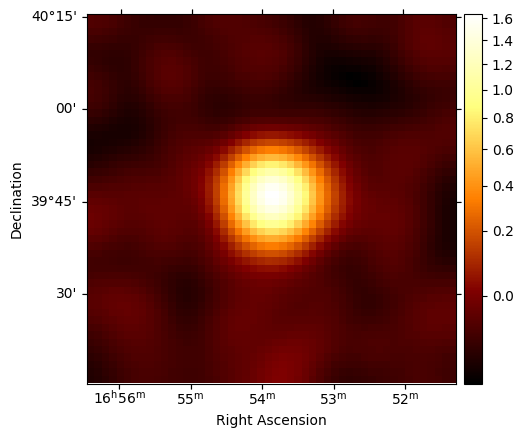

In [8]:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

## Defining custom spatial model

In [9]:
from astropy.coordinates import angular_separation
from gammapy.modeling.models import SpatialModel
from gammapy.modeling import Parameter

class CustomGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "CustomGaussianModel"
    is_energy_dependent = True
    lon_0 = Parameter("lon_0", RA)
    lat_0 = Parameter("lat_0", DEC, min=-90, max=90)
    lon_0.frozen = True
    lat_0.frozen = True

    sigma_1TeV = Parameter("sigma_1TeV", "0.12 deg", min=0)
    sigma_10TeV = Parameter("sigma_10TeV", "0.02 deg", min=0)

    @staticmethod
    def evaluate(lon, lat, energy, lon_0, lat_0, sigma_1TeV, sigma_10TeV):

        sep = angular_separation(lon, lat, lon_0, lat_0)

        # Compute sigma for the given energy using linear interpolation in log energy
        sigma_nodes = u.Quantity([sigma_1TeV, sigma_10TeV])
        energy_nodes = [1, 10] * u.TeV
        log_s = np.log(sigma_nodes.to("deg").value)
        log_en = np.log(energy_nodes.to("TeV").value)
        log_e = np.log(energy.to("TeV").value)
        sigma = np.exp(np.interp(log_e, log_en, log_s)) * u.deg

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma**2)
        return norm * np.exp(exponent)
    
    @property
    def evaluation_radius(self):
        """Evaluation radius (`~astropy.coordinates.Angle`)."""
        return 5 * np.max([self.sigma_1TeV.value, self.sigma_10TeV.value]) * u.deg
    

We define spectral model from table data. To keep overall flux normalization as a free parameter we multiply template spectrum by constant

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

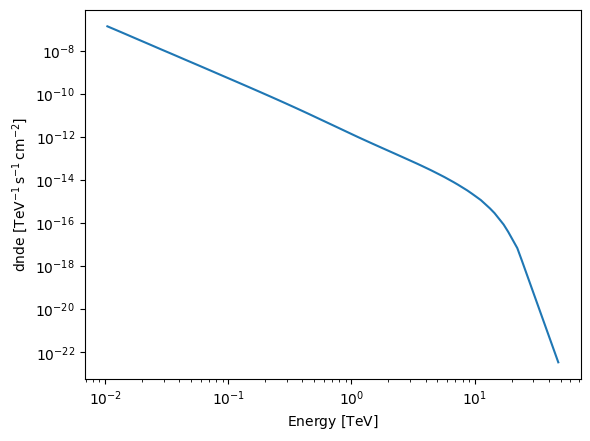

In [10]:
spec_file = 'data/2xphoton_E5e+13_z0.03364_N4000000_EBL12_B1e-12_Lmax5_p1_5.0_0.5_5_p2.4524_crbeam.spec'
specE2 = np.loadtxt(spec_file)
E = specE2[:,0]
flux = specE2[:,1]/E/E
norm_flux = flux[E>=1e12][0]
flux /=  norm_flux

template = TemplateSpectralModel(energy=E*u.eV, values=1e-12*flux)
cm = ConstantSpectralModel(const=1*u.Unit("TeV-1 s-1 cm-2"))
spectral_model = cm*template
spectral_model.plot([0.01, 50] * u.TeV)

Below we use separate models for halo and primary photons

In [11]:
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.3 * u.TeV, energy_max=None
)


halo_spectrum = TemplateSpectralModel(energy=E*u.eV, values=1e-12*flux)
halo_norm = ConstantSpectralModel(const=0.01*u.Unit("TeV-1 s-1 cm-2"))
halo_model = SkyModel(
    spatial_model=CustomGaussianModel(),
    spectral_model=halo_norm*halo_spectrum,
    name='halo',
)

point_spectrum = TemplateSpectralModel(energy=E*u.eV, values=1e-12*flux)
point_norm = ConstantSpectralModel(const=1*u.Unit("TeV-1 s-1 cm-2"))

## we don't add point model since it doesn't help
# point_model = SkyModel(
#     spatial_model=PointSpatialModel(
#         lon_0=RA, lat_0 = DEC, frame='icrs'
#     ),
#     spectral_model = point_norm*point_spectrum,
#     name="point",
# )

bkg_model = FoVBackgroundModel(dataset_name="stacked")

models_stacked = Models([bkg_model, halo_model])

dataset_stacked.models = models_stacked


In [12]:
## this is tricky part: the fit not always converge
## you may need to play with parameters and try different backends

## option 1
#fit = Fit(backend="scipy", optimize_opts={'options':{'maxiter': 1000}})
## option 2
fit = Fit(optimize_opts={"print_level": 1})

result = fit.run(datasets=[dataset_stacked])
result

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 252.341 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.0538575
W MnPosDef Added to diagonal of Error matrix a value 0.553859
W VariableMetricBuilder gdel = -8165.75


In [13]:
display(result.models.to_parameters_table())

<Table length=8>
   model    type     name      value    ... frozen is_norm link prior
   str11    str1    str11     float64   ...  bool    bool  str1  str1
----------- ---- ----------- ---------- ... ------ ------- ---- -----
stacked-bkg             norm 3.6515e-01 ...  False    True           
stacked-bkg             tilt 0.0000e+00 ...   True   False           
stacked-bkg        reference 1.0000e+00 ...   True   False           
       halo            const 6.4064e+00 ...  False    True           
       halo            lon_0 2.5347e+02 ...   True   False           
       halo            lat_0 3.9760e+01 ...   True   False           
       halo       sigma_1TeV 1.1208e-02 ...  False   False           
       halo      sigma_10TeV 2.7782e-02 ...  False   False

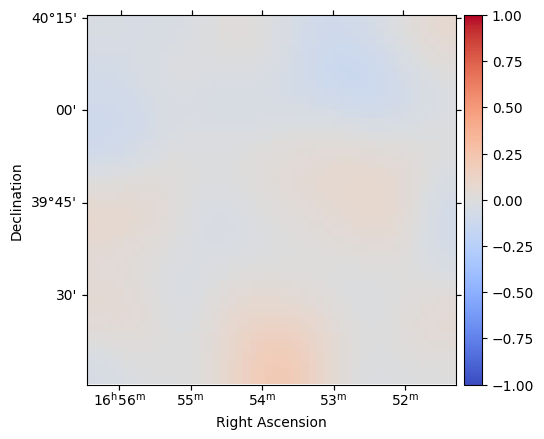

In [14]:
dataset_stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

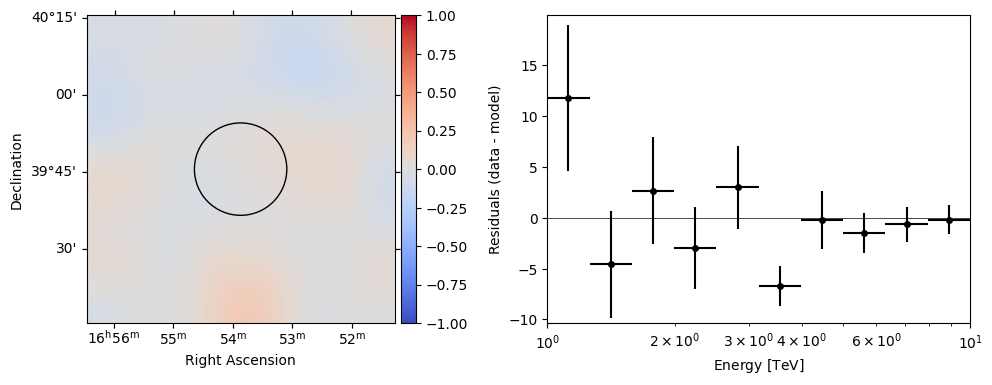

In [15]:
region = CircleSkyRegion(source, radius=0.15 * u.deg)
dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)
plt.show()